In [1]:
# Complete ANN project template for CSC3034 Assignment 2
# - Data loading & basic EDA
# - Preprocessing (missing values, encoding, scaling)
# - Train/test split
# - Build and train ANN (TensorFlow / Keras)
# - Model evaluation: accuracy, confusion matrix, AUC-ROC (binary/multiclass)
# - Cross-validation (StratifiedKFold)
# - Repetitive testing + Optuna hyperparameter tuning
# - Visualization: learning curves, confusion matrix, ROC curve
# - Save model and artifacts

# USAGE:
#     - Edit DATA_PATH, TARGET_COL and basic settings below (marked TODO)
#     - Run: python src/main.py
#     - Or import functions into notebooks (recommended for step-by-step work)

In [2]:
# ======================================
# PIMA DIABETES ANN - Group 13 Assignment 2 Coding
# ======================================
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, f1_score, log_loss, recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
tf.get_logger().setLevel('ERROR')

In [3]:
try:
    from IPython.display import display
except:
    display = None

try:
    import optuna
    OPTUNA_AVAILABLE = True
except:
    OPTUNA_AVAILABLE = False
    print("Optuna not installed - hyperparameter tuning will be skipped")

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


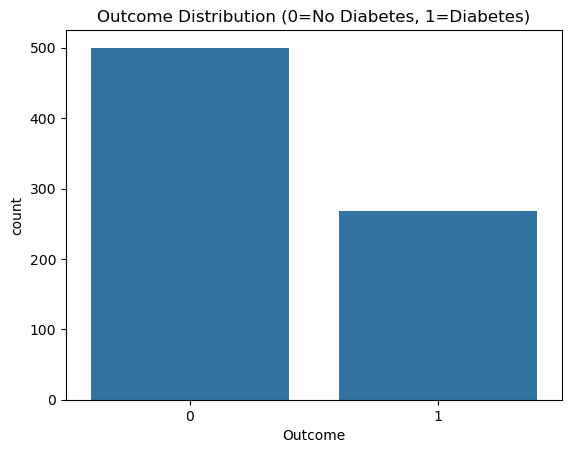

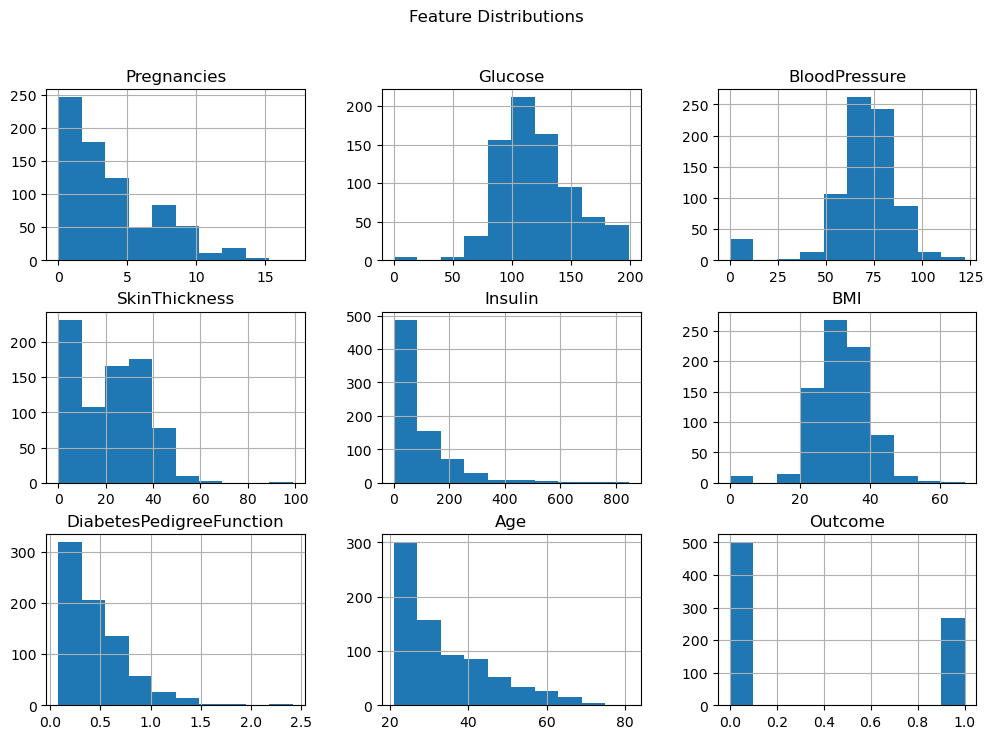

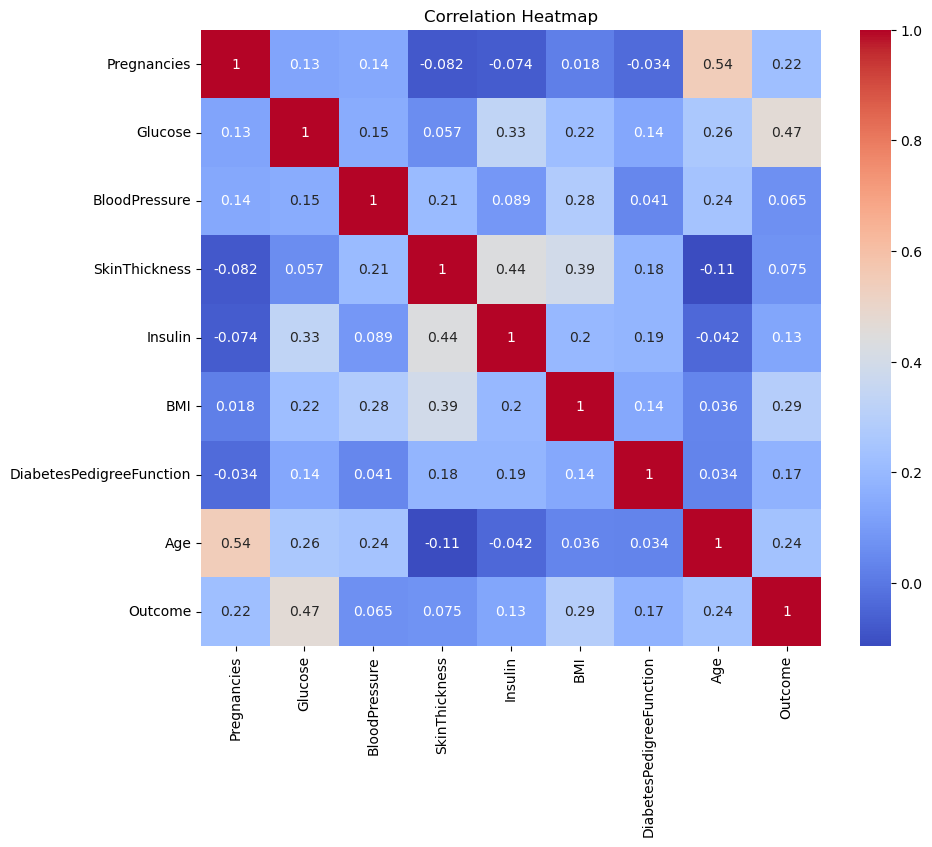

In [4]:
# 1) LOADING OF DATA
data = pd.read_csv("diabetes.csv") # Load PIMA Diabetes dataset
# Show dataset in a tidy table
if display:
    display(
        data.describe().transpose().style.set_table_styles([
            {"selector": "th", "props": [("border", "1px solid black"), ("text-align", "center")]},
            {"selector": "td", "props": [("border", "1px solid black"), ("text-align", "center")]}
        ])
    )
else:
    print(data.describe().transpose())

# VISUALIZATION — DISTRIBUTIONS & CORRELATIONS
# Outcome Distribution
# Visualizing class imbalance (0 = No Diabetes, 1 = Diabetes)
plt.figure()
sns.countplot(x="Outcome", data=data)
plt.title("Outcome Distribution (0=No Diabetes, 1=Diabetes)")
plt.show()

# Feature Histograms
# Histograms for all features
data.hist(figsize=(12,8))
plt.suptitle("Feature Distributions")
plt.show()

# Correlation Heatmap
# Correlation matrix (helps understand which features strongly relate)
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# 2) REPLACE 0 WITH MISSING
# These columns should never be zero in a real medical record
zero_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
# Replace 0 → NaN for proper imputation
for col in zero_columns:
    data[col] = data[col].replace(0, np.nan)

In [6]:
# 3) SPLIT FEATURES & TARGET
X = data.drop("Outcome", axis=1) # 8 health measurements
y = data["Outcome"] # diabetes diagnosis (binary)

In [7]:
# 4) TRAIN-TEST SPLIT
# 80% training, 20% testing — standard ML practice
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [8]:
# 5) IMPUTE MISSING VALUES
imputer = SimpleImputer(strategy="median")

# IMPORTANT: Fit only on training data to avoid data leakage
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test) # Use the same median found in training


In [9]:
# 6) FEATURE SCALING
scaler = StandardScaler()
scaler.fit(X_train)
# Apply scaling to both train & test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Improves generalization and prevents overfitting
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Stop based on validation loss
    patience= 5, # Allow 5 epochs without improvement
    restore_best_weights=True
)

lrp_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor= 0.5, # Reduce LR by half
    patience= 3, 
    min_lr=1e-7, # Avoid LR going too low
    verbose=0
)

In [10]:
# HELPER FUNCTION: Define the Keras Model
def create_model(alpha_value, hl1_dropout, hl2_dropout):
    """
    Creates the Sequential Keras ANN model with the architecture
    and regularization specified in the report.
    """
    model = Sequential([
        # Hidden Layer 1: Dense(32) + ReLU + L2 Regularization
        Dense(32, activation='relu', input_shape=(8,),
              kernel_regularizer=l2(alpha_value)), # L2 weight decay

        # Dropout after Hidden Layer 1 (Rate: 0.25)
        Dropout(hl1_dropout),

        # Hidden Layer 2: Dense(16) + ReLU + L2 Regularization
        Dense(16, activation='relu',
              kernel_regularizer=l2(alpha_value)),

        # Dropout after Hidden Layer 2 (Rate: 0.20)
        Dropout(hl2_dropout),

        # Output Layer: Dense(1) + Sigmoid (Binary Classification)
        Dense(1, activation='sigmoid')
    ])

    # Optimizer: Adam with fixed initial learning rate of 0.001
    # Loss: Binary Cross-Entropy (BCE)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
# 8) TRAIN BASELINE ANN 
# This is the FIRST ANN model (before any hyperparameter tuning).
# It serves as the baseline architecture to compare against the optimized model later.
print("--- Training Keras Baseline ANN Model ---")
# NOTE: We use default alpha (1e-5) and batch_size (32) for the *initial* baseline here
baseline_mlp = create_model(alpha_value=1e-5, hl1_dropout=0.25, hl2_dropout=0.20) # Default/initial L2 is 1e-5
history = baseline_mlp.fit(
    X_train, y_train, 
    epochs= 50,                         # Fixed max_iter=50
    batch_size=32,                      # Fixed batch_size=32
    validation_split=0.1,
    validation_data=(X_test, y_test),
    callbacks=[es_callback, lrp_callback], # Early Stopping and ReduceLROnPlateau implemented
    verbose=0
)
print("Keras Baseline Model Trained.")

--- Training Keras Baseline ANN Model ---


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Keras Baseline Model Trained.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Accuracy: 0.7012987012987013

Confusion Matrix:



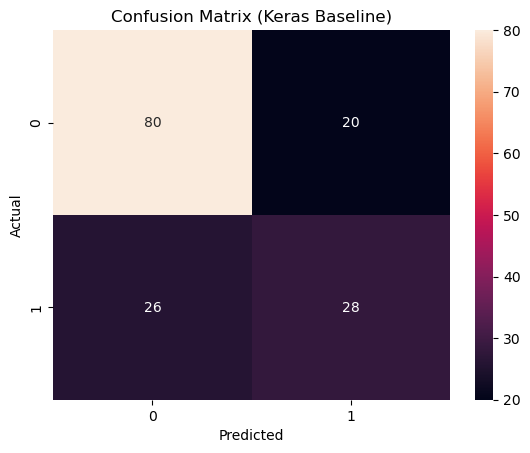


Classification Report (Table View):


,precision,recall,f1-score,support
0,0.754717,0.800000,0.776699,100.000000
1,0.583333,0.518519,0.549020,54.000000
accuracy,0.701299,0.701299,0.701299,0.701299
macro avg,0.669025,0.659259,0.662859,154.000000
weighted avg,0.694621,0.701299,0.696863,154.000000



AUC: 0.797962962962963
Test Set Log Loss (Binary Cross-Entropy): 0.5179


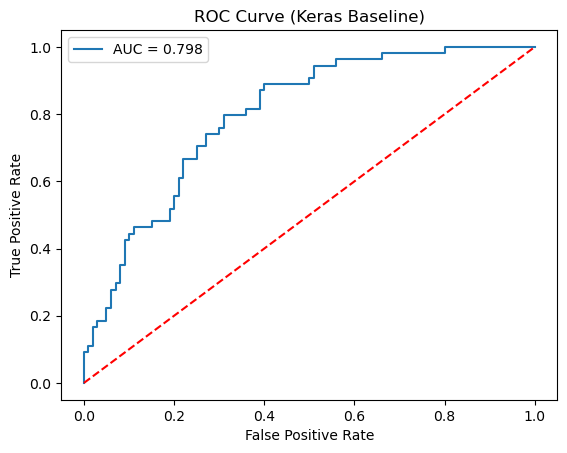

In [12]:
# 9) EVALUATION (Accuracy + ROC/AUC)
# Predict probabilities (for ROC/AUC/LogLoss)
y_prob = baseline_mlp.predict(X_test).ravel()
# Predict class labels (for Accuracy/CM/Report)
predictions = (y_prob > 0.5).astype(int)

# ---- Accuracy ----
acc = accuracy_score(y_test, predictions)
print("\nAccuracy:", acc)

# ---- Confusion Matrix ----
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, predictions)

# Confusion Matrix Plot
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix (Keras Baseline)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
report = classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\nClassification Report (Table View):")
try:
    display(report_df.style.set_table_styles([
        {"selector": "th", "props": [("border", "1px solid black"), ("text-align", "center")]},
        {"selector": "td", "props": [("border", "1px solid black"), ("text-align", "center")]}
    ]))
except:
    print(report_df)

# AUC ROC
auc = roc_auc_score(y_test, y_prob)
print("\nAUC:", auc)

# Log Loss (Binary Cross-Entropy)
logloss = log_loss(y_test, y_prob)
print(f"Test Set Log Loss (Binary Cross-Entropy): {logloss:.4f}")

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'r--')
plt.title("ROC Curve (Keras Baseline)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [13]:
# 10) CROSS VALIDATION
# We need the Scikeras wrapper to use the Keras model in the sklearn cross_val_score function.
# Wrapper function for the Keras model (needed for Scikeras)
def wrapped_keras_model():
    # Use create_model helper with default alpha
    return create_model(alpha_value=1e-5, hl1_dropout=0.25, hl2_dropout=0.20) 

# Pipeline ensures preprocessing (imputation, scaling) happens INSIDE each fold
cv_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
    # Use KerasClassifier wrapper for CV
    ('mlp', KerasClassifier(
        model=wrapped_keras_model, 
        epochs= 50, 
        batch_size=32, 
        callbacks=[es_callback, lrp_callback],
        random_state=42, 
        verbose=0
    ))
])

# The KerasClassifier wrapper handles the fit and predict methods for sklearn's cross_val_score
cv_scores = cross_val_score(cv_pipeline, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print("\nCross Validation Scores (Keras Model):", cv_scores)
print("Mean CV Accuracy (Keras Model):", cv_scores.mean())

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:171: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer


Cross Validation Scores (Keras Model): [0.72077922 0.80519481 0.75974026 0.75816993 0.75816993]
Mean CV Accuracy (Keras Model): 0.7604108309990663


In [14]:
# 11) INFERENCING
# Predict for new patient
new_patient = np.array([[6,148,72,35,0,33.6,0.627,50]])

# Apply the same sequence of preprocessing as training
new_patient_imputed = imputer.transform(new_patient)
new_patient_scaled = scaler.transform(new_patient_imputed)
prediction = baseline_mlp.predict(new_patient_scaled)

print("New patient prediction (0=No, 1=Diabetes):", (prediction > 0.5).astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
New patient prediction (0=No, 1=Diabetes): [[1]]


c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [15]:
# 12) REPETITIVE PARAMETER TESTING
# Tests different single-layer architectures (5, 10, 20 neurons)
# to illustrate how network width affects accuracy.
layer_options = [(5), (10), (20)]
print("\nTesting different hidden layer sizes (Single Layer with Dropout/L2):")

for layers in layer_options:
    # --- Create a model with single hidden layer and default regularization/dropout ---
    test_model = Sequential([
        Dense(layers, activation='relu', input_shape=(8,), kernel_regularizer=l2(1e-5)),
        Dropout(0.20),
        Dense(1, activation='sigmoid')
    ])
    test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # --- Train the model ---
    test_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[es_callback], verbose=0)
    
    # --- Evaluate the model ---
    _, score = test_model.evaluate(X_test, y_test, verbose=0)
    print(f"Layers: ({layers},) Accuracy: {score:.4f}")

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Testing different hidden layer sizes (Single Layer with Dropout/L2):
Layers: (5,) Accuracy: 0.6429
Layers: (10,) Accuracy: 0.6234
Layers: (20,) Accuracy: 0.6104


In [16]:
# 13) OPTUNA OPTIMIZATION (TUNING ALPHA & BATCH_SIZE)
# This stage tunes the hyperparameters:
#   - L2 regularization (alpha)
#   - batch_size  
# to improve generalization and accuracy.

best_params = {
    'alpha': 1e-5, 
    'batch_size': 32,
    'hl1_dropout': 0.25,
    'hl2_dropout': 0.20
}

if OPTUNA_AVAILABLE:
    print("\n--- Running Optuna Optimization (Tuning alpha & batch_size) ---")

    def objective(trial):
        # 1. Hyperparameter Search Space 
        # L2 weight decay tuned between 10^-5 to 10^-3
        alpha = trial.suggest_float("alpha", 0.00001, 0.001, log=True) 
        # Batch size tuned on the search space {16, 32, 64}
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
        hl1_dropout = trial.suggest_float("hl1_dropout", 0.2, 0.3) # Dropout [0.2, 0.3]
        hl2_dropout = trial.suggest_float("hl2_dropout", 0.2, 0.3) # Dropout [0.2, 0.3]

        # 2. Model Instantiation
        model = create_model(
            alpha_value=alpha, 
            hl1_dropout = hl1_dropout, 
            hl2_dropout = hl2_dropout
        )
        
        # 3. Model Training
        model.fit(
            X_train, y_train, 
            epochs= 50,
            batch_size=batch_size,
            validation_split=0.1,
            callbacks=[es_callback, lrp_callback],
            verbose=0
        )

        # 4. Evaluation
        loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
        return accuracy

    # Using the same seed for reproducibility as in the original notebook
    # TPESampler = Bayesian optimization-like search
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=20) 

    print("Best parameters:", study.best_params)
    
    # Save optimized hyperparameters
    best_params['alpha'] = study.best_params['alpha']
    best_params['batch_size'] = study.best_params['batch_size']

[I 2025-12-12 20:26:36,424] A new study created in memory with name: no-name-c4153ab7-2a9a-4d21-bbd6-9e2d6ddc1bde



--- Running Optuna Optimization (Tuning alpha & batch_size) ---


[I 2025-12-12 20:26:43,727] Trial 0 finished with value: 0.7850162982940674 and parameters: {'alpha': 5.6115164153345e-05, 'batch_size': 16, 'hl1_dropout': 0.21560186404424367, 'hl2_dropout': 0.21559945203362027}. Best is trial 0 with value: 0.7850162982940674.
[I 2025-12-12 20:26:48,811] Trial 1 finished with value: 0.4869706928730011 and parameters: {'alpha': 1.3066739238053272e-05, 'batch_size': 16, 'hl1_dropout': 0.20205844942958026, 'hl2_dropout': 0.29699098521619943}. Best is trial 0 with value: 0.7850162982940674.
[I 2025-12-12 20:26:54,232] Trial 2 finished with value: 0.6449511647224426 and parameters: {'alpha': 0.000462258900102083, 'batch_size': 16, 'hl1_dropout': 0.23042422429595377, 'hl2_dropout': 0.2524756431632238}. Best is trial 0 with value: 0.7850162982940674.
[I 2025-12-12 20:26:58,064] Trial 3 finished with value: 0.6758957505226135 and parameters: {'alpha': 7.309539835912905e-05, 'batch_size': 32, 'hl1_dropout': 0.22921446485352182, 'hl2_dropout': 0.236636184329369

Best parameters: {'alpha': 0.000239762272742407, 'batch_size': 16, 'hl1_dropout': 0.21595525678425312, 'hl2_dropout': 0.23732015096316036}



--- Training Final Optimized ANN Model (Keras) ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Final ANN Accuracy: 0.6688
LR Baseline Accuracy: 0.6948


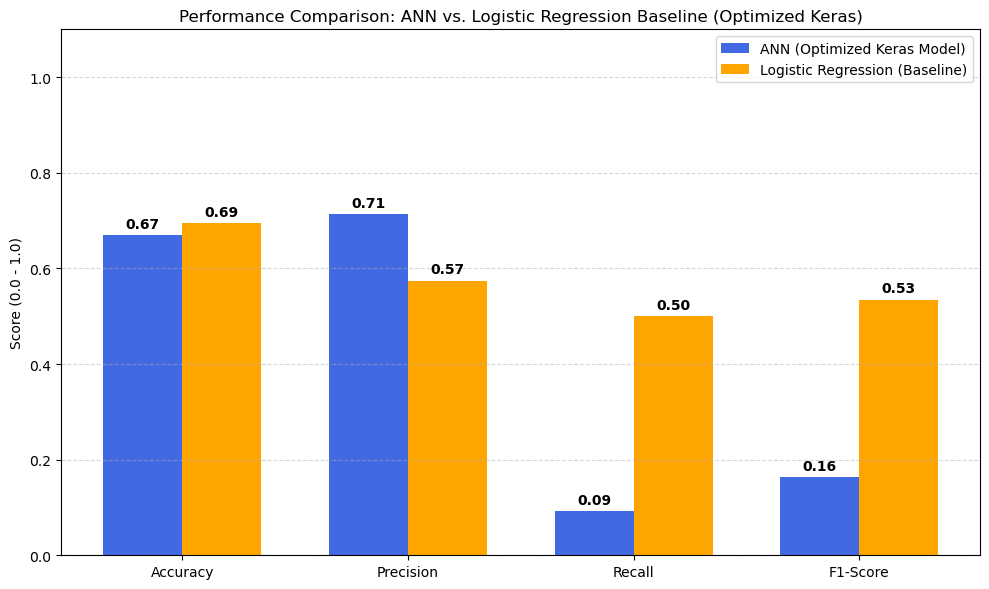

In [17]:
# 14) FINAL MODEL & BASELINE COMPARISON 
# --- A. Final Optimized ANN Model (Keras) ---
# NOTE: Using best_params found from Optuna (batch_size and alpha)
print("\n--- Training Final Optimized ANN Model (Keras) ---")
final_mlp = create_model(alpha_value=best_params['alpha'], hl1_dropout=best_params['hl1_dropout'], hl2_dropout=best_params['hl2_dropout'])

# Train with optimized parameters
final_mlp.fit(
    X_train, y_train, 
    epochs= 50,                  
    batch_size=best_params['batch_size'], 
    validation_split=0.1,
    callbacks=[es_callback, lrp_callback],
    verbose=0
)

# Calculate ANN Optimized Metrics
ann_prob = final_mlp.predict(X_test).ravel()
ann_preds = (ann_prob > 0.5).astype(int)
ann_acc = accuracy_score(y_test, ann_preds)
ann_prec = precision_score(y_test, ann_preds)
ann_rec = recall_score(y_test, ann_preds)
ann_f1 = f1_score(y_test, ann_preds)
print(f"Final ANN Accuracy: {ann_acc:.4f}")

# --- B. Train Logistic Regression Baseline (sklearn) ---
# Re-running LR Baseline for comparison
log_model = LogisticRegression(random_state=42, solver='liblinear')
log_model.fit(X_train, y_train) 
lr_preds = log_model.predict(X_test) # Predict on the 8-feature test data

# Calculate LR Metrics
lr_acc = accuracy_score(y_test, lr_preds)
lr_prec = precision_score(y_test, lr_preds)
lr_rec = recall_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)
print(f"LR Baseline Accuracy: {lr_acc:.4f}")

# --- C. COMPARATIVE BAR CHART (Final Visualization) ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
ann_scores = [ann_acc, ann_prec, ann_rec, ann_f1]
lr_scores = [lr_acc, lr_prec, lr_rec, lr_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, ann_scores, width, label='ANN (Optimized Keras Model)', color='royalblue')
rects2 = ax.bar(x + width/2, lr_scores, width, label='Logistic Regression (Baseline)', color='orange')

ax.set_ylabel('Score (0.0 - 1.0)')
ax.set_title('Performance Comparison: ANN vs. Logistic Regression Baseline (Optimized Keras)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig("ann_lr_bar_comparison_keras.png")
plt.show()